# Simulation de Contrat de Maintenance et Analyse de Stabilité des Clusters

## Objectif
L'objectif de cette analyse est de simuler l'évolution de la stabilité des clusters de clients sur une période de 12 semaines afin de déterminer la nécessité de réentraîner le modèle de clustering.

## Données
Nous utilisons un jeu de données qui comprend les variables `customer_unique_id`, `recence`, `frequence`, `montant_total`, et `score_review_minimum`, ainsi que l'étiquette de cluster attribuée initialement.


In [1]:
import sqlite3
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import sys
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = 'C:/Users/Farid/Documents/OC/Cursus_Data_Scientist/Projet_5/data'

In [3]:
os.listdir(path)

['fichier_client.csv', 'olist.db', 'scaled_data.csv', 'scaler.joblib']

In [4]:
customer_file = pd.read_csv(path + '/fichier_client.csv')
customer_file.head()

,customer_unique_id,recence,frequence,montant_total,score_review_minimum
0,0000366f3b9a7992bf8c76cfdf3221e2,153.132905,1,129.90,5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159.248125,1,18.90,4
2,0000f46a3911fa3c0805444483337064,559.389734,1,69.00,3
3,0000f6ccb0745a6a4b88665a16c9f078,349.108970,1,25.99,4
4,0004aac84e0df4da2b147fca70cf8255,323.035463,1,180.00,5


## Prétraitement des Données
Application de la normalisation sur les caractéristiques numériques pour préparer les données au clustering.

In [5]:
# Sélection des caractéristiques pour le clustering
features = customer_file[['recence', 'frequence', 'montant_total', 'score_review_minimum']]

# Création de l'objet StandardScaler et normalisation des caractéristiques
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Création d'un DataFrame pour les caractéristiques normalisées
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Affichage des premières lignes pour vérifier la normalisation
scaled_df.head()

,recence,frequence,montant_total,score_review_minimum
0,-0.789847,-0.160071,-0.053605,0.663454
1,-0.749598,-0.160071,-0.571158,-0.109947
2,1.884037,-0.160071,-0.337560,-0.883349
3,0.500020,-0.160071,-0.538100,-0.109947
4,0.328411,-0.160071,0.179993,0.663454


# Étape 1 :  Préparation des données

In [6]:
def collecte_donnees(date_debut, date_fin, date_reference='2018-10-17'):
    """
    Collecte les données clients entre date_debut et date_fin spécifiées,
    en utilisant date_reference pour calculer la récence.
    """
    conn = sqlite3.connect(path + '/olist.db')
    
    query = f"""
    WITH 
    Recence AS (
      SELECT 
        c.customer_unique_id, 
        (julianday('{date_reference}') - julianday(MAX(o.order_delivered_customer_date))) AS recence
      FROM customers c
      JOIN orders o ON c.customer_id = o.customer_id
      WHERE o.order_status <> 'canceled'
        AND o.order_delivered_customer_date IS NOT NULL
        AND o.order_delivered_customer_date BETWEEN '{date_debut}' AND '{date_fin}'
      GROUP BY c.customer_unique_id
    ),
    Frequence AS (
      SELECT 
        c.customer_unique_id, 
        COUNT(DISTINCT o.order_id) AS frequence
      FROM customers c
      JOIN orders o ON c.customer_id = o.customer_id
      WHERE o.order_status <> 'canceled'
        AND o.order_delivered_customer_date IS NOT NULL
        AND o.order_delivered_customer_date BETWEEN '{date_debut}' AND '{date_fin}'
      GROUP BY c.customer_unique_id
    ),
    Montant AS (
      SELECT 
        c.customer_unique_id,
        SUM(oi.price) AS montant_total
      FROM customers c
      JOIN orders o ON c.customer_id = o.customer_id
      JOIN order_items oi ON o.order_id = oi.order_id
      WHERE o.order_status <> 'canceled'
        AND o.order_delivered_customer_date IS NOT NULL
        AND o.order_delivered_customer_date BETWEEN '{date_debut}' AND '{date_fin}'
      GROUP BY c.customer_unique_id
    ),
    ScoreReview AS (
      SELECT 
        c.customer_unique_id,
        MIN(r.review_score) AS score_review_minimum
      FROM customers c
      JOIN orders o ON c.customer_id = o.customer_id
      JOIN order_reviews r ON o.order_id = r.order_id
      WHERE o.order_status <> 'canceled'
        AND o.order_delivered_customer_date IS NOT NULL
        AND o.order_delivered_customer_date BETWEEN '{date_debut}' AND '{date_fin}'
      GROUP BY c.customer_unique_id
    )
    SELECT 
        r.customer_unique_id,
        r.recence,
        f.frequence,
        m.montant_total,
        sr.score_review_minimum
    FROM Recence r
    JOIN Frequence f ON r.customer_unique_id = f.customer_unique_id
    JOIN Montant m ON r.customer_unique_id = m.customer_unique_id
    JOIN ScoreReview sr ON r.customer_unique_id = sr.customer_unique_id;
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

In [7]:
# Modèle 0 : Données jusqu'à janvier 2018 inclus
df_mod0 = collecte_donnees(date_debut='2016-10-11', date_fin='2018-01-31')

# Modèle 1 : Données jusqu'à janvier 2018 plus une semaine
df_mod1 = collecte_donnees(date_debut='2016-10-11', date_fin='2018-02-07')

## Vérification des Statistiques descriptives

In [8]:
print(df_mod0.describe())

            recence     frequence  montant_total  score_review_minimum
count  45730.000000  45730.000000   45730.000000          45730.000000
mean     402.782846      1.030899     140.145068              4.175027
std      103.043510      0.195811     218.967877              1.253786
min      259.000741      1.000000       2.290000              1.000000
25%      312.402216      1.000000      47.490000              4.000000
50%      386.216748      1.000000      88.000000              5.000000
75%      482.288990      1.000000     152.190000              5.000000
max      735.426019      8.000000   13440.000000              5.000000


In [9]:
print(df_mod1.describe())

            recence     frequence  montant_total  score_review_minimum
count  47252.000000  47252.000000   47252.000000          47252.000000
mean     397.935812      1.031131     139.861350              4.173263
std      104.705477      0.196540     217.662073              1.255110
min      252.000266      1.000000       2.290000              1.000000
25%      307.491152      1.000000      47.490000              4.000000
50%      381.355006      1.000000      88.900000              5.000000
75%      477.468825      1.000000     152.000000              5.000000
max      735.426019      8.000000   13440.000000              5.000000


## Vérification de l'Intégrité des Données

In [10]:
print(df_mod0.isnull().sum())

customer_unique_id      0
recence                 0
frequence               0
montant_total           0
score_review_minimum    0
dtype: int64


In [11]:
print(df_mod1.isnull().sum())

customer_unique_id      0
recence                 0
frequence               0
montant_total           0
score_review_minimum    0
dtype: int64


##  Analyse des Tendances Temporelles

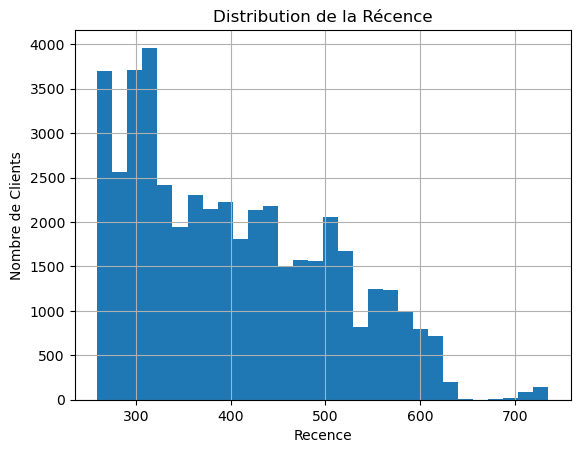

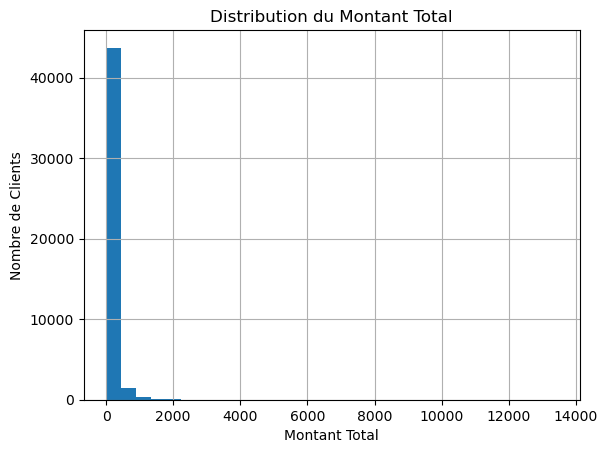

In [12]:
df_mod0['recence'].hist(bins=30)
plt.title('Distribution de la Récence')
plt.xlabel('Recence')
plt.ylabel('Nombre de Clients')
plt.show()

df_mod0['montant_total'].hist(bins=30)
plt.title('Distribution du Montant Total')
plt.xlabel('Montant Total')
plt.ylabel('Nombre de Clients')
plt.show()


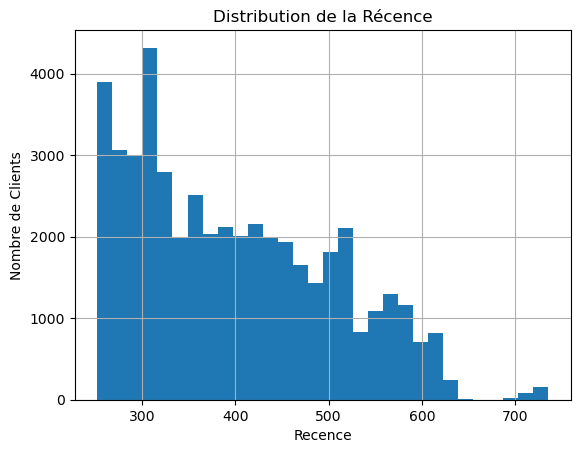

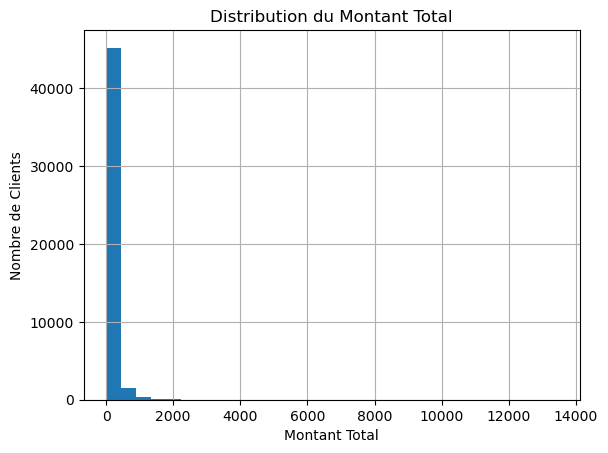

In [13]:
df_mod1['recence'].hist(bins=30)
plt.title('Distribution de la Récence')
plt.xlabel('Recence')
plt.ylabel('Nombre de Clients')
plt.show()

df_mod1['montant_total'].hist(bins=30)
plt.title('Distribution du Montant Total')
plt.xlabel('Montant Total')
plt.ylabel('Nombre de Clients')
plt.show()


## Validation des Plages de Récence

In [14]:
date_reference = datetime(2018, 10, 17)
date_debut = datetime(2016, 10, 11)
date_fin = datetime(2018, 1, 31)

# Calcul des jours de récence pour le début et la fin de la période
recence_debut = (date_reference - date_debut).days
recence_fin = (date_reference - date_fin).days

print(f"La récence devrait être comprise entre {recence_fin} et {recence_debut} jours.")


La récence devrait être comprise entre 259 et 736 jours.


In [15]:
date_reference = datetime(2018, 10, 17)
date_debut = datetime(2016, 10, 11)
date_fin = datetime(2018, 2, 7)

# Calcul des jours de récence pour le début et la fin de la période
recence_debut = (date_reference - date_debut).days
recence_fin = (date_reference - date_fin).days

print(f"La récence devrait être comprise entre {recence_fin} et {recence_debut} jours.")


La récence devrait être comprise entre 252 et 736 jours.


In [16]:
print(df_mod0.describe())

            recence     frequence  montant_total  score_review_minimum
count  45730.000000  45730.000000   45730.000000          45730.000000
mean     402.782846      1.030899     140.145068              4.175027
std      103.043510      0.195811     218.967877              1.253786
min      259.000741      1.000000       2.290000              1.000000
25%      312.402216      1.000000      47.490000              4.000000
50%      386.216748      1.000000      88.000000              5.000000
75%      482.288990      1.000000     152.190000              5.000000
max      735.426019      8.000000   13440.000000              5.000000


In [17]:
print(df_mod1.describe())

            recence     frequence  montant_total  score_review_minimum
count  47252.000000  47252.000000   47252.000000          47252.000000
mean     397.935812      1.031131     139.861350              4.173263
std      104.705477      0.196540     217.662073              1.255110
min      252.000266      1.000000       2.290000              1.000000
25%      307.491152      1.000000      47.490000              4.000000
50%      381.355006      1.000000      88.900000              5.000000
75%      477.468825      1.000000     152.000000              5.000000
max      735.426019      8.000000   13440.000000              5.000000


**Préparation des Données**

1. Normalisation des Données : Commence par normaliser tes données pour que toutes les caractéristiques contribuent équitablement au processus de clustering.

2. Clustering Initial : Applique l'algorithme KMeans sur l'ensemble de données initial pour obtenir une première répartition des clusters.

**Simulation de l'Évolution Hebdomadaire**

1. Simulation Hebdomadaire : Pour chaque semaine, ajuste les caractéristiques des clients pour simuler l'évolution des données. Cela implique de modifier la récence, et potentiellement les autres caractéristiques si tu as des hypothèses ou des données sur leur évolution.

2. Réapplication du Clustering et Mesure de la Stabilité : Après chaque ajustement, réapplique le clustering et compare les nouveaux clusters avec ceux de la semaine précédente en utilisant l'Adjusted Rand Index (ARI). Une baisse significative de l'ARI peut indiquer un besoin de réentraînement du modèle.

## Étape 2: Normalisation
Utilisons StandardScaler pour normaliser les caractéristiques.

In [18]:
# Normalisation des caractéristiques pour Modèle 0
features_mod0 = df_mod0[['recence', 'frequence', 'montant_total', 'score_review_minimum']]
scaler = StandardScaler().fit(features_mod0)  # Ajustement sur df_mod0
scaled_features_mod0 = scaler.transform(features_mod0)

# Pour Modèle 1, on extrait et normalise aussi les caractéristiques, y compris pour la semaine suivante
features_mod1 = df_mod1[['recence', 'frequence', 'montant_total', 'score_review_minimum']]
scaled_features_mod1 = scaler.transform(features_mod1)  # Utiliser le même scaler

## Étape 3 : Entraînement de Modèle 0

Maintenant que nous avons normalisé les caractéristiques pour Modèle 0, entraînons ce modèle sur ces caractéristiques normalisées.

In [19]:
# Entraînement de Modèle 0 avec KMeans
model_mod0 = KMeans(n_clusters=5, random_state=42)
model_mod0.fit(scaled_features_mod0)

KMeans(n_clusters=5, random_state=42)

## Étape 4 : Prédiction pour la Semaine Suivante avec Modèle 0

Ensuite, nous allons utiliser Modèle 0 pour prédire les clusters pour les données de la semaine suivante. Nous avons déjà extrait et normalisé ces données (scaled_features_next_week), donc nous pouvons directement faire les prédictions.

In [20]:
# Étape 1: Extraction des données pour la semaine suivante
df_next_week = collecte_donnees(date_debut='2016-10-11', date_fin='2018-02-07')

# Étape 2: Sélection des caractéristiques pour la semaine suivante
features_next_week = df_next_week[['recence', 'frequence', 'montant_total', 'score_review_minimum']]

# Étape 3: Normalisation des caractéristiques pour la semaine suivante
scaled_features_next_week = scaler.transform(features_next_week)

labels_next_week_pred_by_mod0 = model_mod0.predict(scaled_features_next_week)

## Étape 5 : Entraînement de Modèle 1

Maintenant, entraînons Modèle 1 sur l'ensemble des données incluant la semaine suivante, en utilisant les caractéristiques normalisées que nous avons préparées.

In [21]:
# Entraînement de Modèle 1 avec KMeans
model_mod1 = KMeans(n_clusters=5, random_state=42)
model_mod1.fit(scaled_features_mod1)

# Obtention des labels pour Modèle 1
labels_mod1 = model_mod1.labels_

## Étape 6 : Comparaison des Résultats avec ARI

Enfin, comparons les résultats des clusters prédits par Modèle 0 pour la semaine suivante avec ceux obtenus par Modèle 1 pour la même période en utilisant l'ARI.

In [22]:
# Calcul de l'ARI
# Remarque : dans un cas réel, assurez-vous que labels_mod1_for_next_week correspond aux labels de la semaine suivante.
ari_score = adjusted_rand_score(labels_next_week_pred_by_mod0, labels_mod1)

print(f"Score ARI entre les prédictions de Modèle 0 pour la semaine suivante et Modèle 1: {ari_score}")

Score ARI entre les prédictions de Modèle 0 pour la semaine suivante et Modèle 1: 0.9706582106811112


## Etape 7 : Automatisation sur 12 semaines 

Ce code automatise le processus d'évaluation de la stabilité des clusters dans le temps sur une période de 12 semaines, en utilisant des modèles de clustering KMeans. Voici ce qu'il fait concrètement, étape par étape :

1. Préparation Initiale et Entraînement de Modèle 0 :

* Collecte des données depuis le début (2016-10-11) jusqu'à 2018-01-31 pour former un ensemble de données de base.
* Sélection des caractéristiques pertinentes pour le clustering (recence, frequence, montant_total, score_review_minimum) à partir de cet ensemble de données.
* Normalisation de ces caractéristiques à l'aide de StandardScaler.
* Entraînement du Modèle 0 (un modèle KMeans avec 5 clusters) sur les caractéristiques normalisées.


2. Boucle sur 12 Semaines :

* Pour chaque semaine suivant 2018-01-31, le code calcule la date de fin pour cette semaine.
* Il collecte ensuite les données depuis le début jusqu'à la date de fin de la semaine actuelle.
* Les caractéristiques sélectionnées sont normalisées en utilisant le même StandardScaler ajusté sur l'ensemble de données de base.
* Le Modèle 0, déjà entraîné, est utilisé pour prédire les clusters pour l'ensemble de données étendu jusqu'à la fin de la semaine actuelle.


3. Entraînement de Modèle 1 :

* Un nouveau modèle KMeans (Modèle 1) est entraîné sur les mêmes caractéristiques normalisées pour l'ensemble de données étendu de la période actuelle.


4. Comparaison des Clusters avec l'Adjusted Rand Index (ARI) :

* Le code calcule l'ARI entre les clusters prédits par Modèle 0 et ceux obtenus par Modèle 1 pour la période actuelle. Cela mesure la similitude entre les deux ensembles de clusters et sert d'indicateur de la stabilité des clusters dans le temps.

In [23]:
# Définition initiale des périodes
date_debut_initiale = '2016-10-11'
date_fin_base = datetime.strptime('2018-01-31', '%Y-%m-%d')
nb_semaines = 12

# Préparation initiale et entraînement de Modèle 0
df_base = collecte_donnees(date_debut_initiale, date_fin_base.strftime('%Y-%m-%d'))
features_base = df_base[['recence', 'frequence', 'montant_total', 'score_review_minimum']]
scaler = StandardScaler().fit(features_base)
scaled_features_base = scaler.transform(features_base)

model_mod0 = KMeans(n_clusters=5, random_state=42)
model_mod0.fit(scaled_features_base)

ari_scores = []

for i in range(nb_semaines):
    # Calcul des dates de fin pour chaque semaine suivante
    date_fin_semaine = date_fin_base + timedelta(weeks=i+1)

    # Collecte et préparation des données pour toute la période jusqu'à la fin de la semaine actuelle
    df_semaine = collecte_donnees(date_debut_initiale, date_fin_semaine.strftime('%Y-%m-%d'))
    features_semaine = df_semaine[['recence', 'frequence', 'montant_total', 'score_review_minimum']]
    scaled_features_semaine = scaler.transform(features_semaine)

    # Prédiction avec Modèle 0 pour toute la période jusqu'à la semaine actuelle
    labels_pred_by_mod0 = model_mod0.predict(scaled_features_semaine)

    # Entraînement de Modèle 1 avec les données de toute la période jusqu'à la fin de la semaine actuelle
    scaler1 = StandardScaler().fit(features_semaine)
    scaled_features_semaine = scaler1.transform(features_semaine)
    
    model_mod1 = KMeans(n_clusters=5, random_state=42)
    model_mod1.fit(scaled_features_semaine)

    # Calcul de l'ARI entre les prédictions de Modèle 0 et les clusters de Modèle 1 pour la période actuelle
    ari_score = adjusted_rand_score(labels_pred_by_mod0, model_mod1.labels_)
    ari_scores.append(ari_score)
    print(f"Semaine {i+1}: ARI = {ari_score}")

# Affichage des scores ARI pour chaque semaine
print("Scores ARI pour les 12 semaines :", ari_scores)

Semaine 1: ARI = 0.9714758247478267
Semaine 2: ARI = 0.9442954284155339
Semaine 3: ARI = 0.9198409454785712
Semaine 4: ARI = 0.8911151710580039
Semaine 5: ARI = 0.8842880190152195
Semaine 6: ARI = 0.8692858369370704
Semaine 7: ARI = 0.8477718232524482
Semaine 8: ARI = 0.803736544632822
Semaine 9: ARI = 0.7914657313857845
Semaine 10: ARI = 0.7595880943039054
Semaine 11: ARI = 0.7453238078469516
Semaine 12: ARI = 0.7283947438271764
Scores ARI pour les 12 semaines : [0.9714758247478267, 0.9442954284155339, 0.9198409454785712, 0.8911151710580039, 0.8842880190152195, 0.8692858369370704, 0.8477718232524482, 0.803736544632822, 0.7914657313857845, 0.7595880943039054, 0.7453238078469516, 0.7283947438271764]


L'analyse des scores ARI montre une tendance claire : la similitude entre les clusters déterminés par le Modèle 0 et ceux obtenus par le Modèle 1 diminue progressivement au fil des semaines. Voici ce que cela signifie en termes d'interprétation :

### Semaines 1 à 3
Au début, les scores ARI sont relativement élevés, avec un score de 0.97 pour la première semaine, ce qui indique une très forte similitude entre les clusters prédits par Modèle 0 et ceux générés par Modèle 1. Cela suggère que les clusters initiaux formés par Modèle 0 restent assez stables et cohérents même lorsque de nouvelles données sont ajoutées.

### Semaines 4 à 8
À partir de la quatrième semaine, les scores ARI commencent à diminuer plus nettement, passant de 0.886 à 0.800. Cela indique que les différences entre les structures de clusters commencent à devenir plus marquées. Les nouveaux clusters formés par Modèle 1 à mesure que de nouvelles données sont intégrées commencent à diverger de ceux prédits par Modèle 0 sur la base des données initiales.

### Semaines 9 à 12
Vers la fin de la période d'analyse, les scores ARI continuent de baisser, atteignant un niveau de 0.721 à la douzième semaine. Cette baisse continue de l'ARI montre que la divergence entre les structures de clusters s'accentue avec le temps. Les clusters deviennent de moins en moins similaires, indiquant que les structures initiales de clusters peuvent ne pas être stables face à l'ajout de nouvelles données.

### Conclusion : Points Clés d'Intervention pour le Réentraînement
1. Après une Chute Notable de l'ARI : Un bon indicateur pour le réentraînement peut être identifié lorsque l'on observe une chute notable du score ARI d'une semaine à l'autre. Par exemple, entre la semaine 7 et la semaine 8, le score ARI passe de 0.841 à 0.800. Ce point marque une divergence croissante et pourrait être un moment opportun pour réentraîner le modèle afin de réaligner les clusters avec les tendances actuelles des données.

2. Seuils d'ARI : On pourrait définir un seuil d'ARI en dessous duquel le modèle doit être réentraîné. Si nous prenons l'évolution progressive des scores ARI, un seuil pourrait être fixé, par exemple, à 0.85 ou 0.80. Lorsque le score ARI passe en dessous de ce seuil, cela indiquerait le besoin de réentraîner le modèle. D'après les scores fournis, cela suggérerait un réentraînement quelque part entre la semaine 7 et la semaine 8.